In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_sprint_speed
%matplotlib inline 

In [2]:
data_2023 = pd.read_csv('./data/2023_hit_data.csv')
data_2024 = pd.read_csv('./data/2024_hit_data.csv')

### Transform Data

In [3]:
data_2023['events'].unique()

array(['field_out', 'strikeout', 'single', 'walk', 'fielders_choice',
       'field_error', 'double', 'grounded_into_double_play',
       'hit_by_pitch', 'home_run', 'force_out', 'fielders_choice_out',
       'sac_fly', 'triple', 'truncated_pa', 'sac_bunt',
       'strikeout_double_play', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'triple_play'], dtype=object)

In [4]:
data_2023['description'].unique()

array(['hit_into_play', 'swinging_strike', 'called_strike', 'ball',
       'foul_tip', 'swinging_strike_blocked', 'hit_by_pitch',
       'blocked_ball', 'foul', 'foul_bunt', 'missed_bunt',
       'bunt_foul_tip', 'pitchout'], dtype=object)

In [5]:
non_included_events = ['sac_bunt', 'catcher_interf', 'truncated_pa']

In [6]:
def transform_data(df, features):
    processed_df = df.copy()
    processed_df = processed_df.loc[processed_df['description'] == 'hit_into_play', :]
    processed_df = processed_df[~processed_df['events'].isin(non_included_events)]
    conditions_tb = [(processed_df['events'] == 'single'), (processed_df['events'] == 'double'), (processed_df['events'] == 'triple'), (processed_df['events'] == 'home_run')]
    choices_tb = [1, 2, 3, 4]

    processed_df = processed_df.loc[:, features]
    processed_df['tb'] = np.select(conditions_tb, choices_tb, default = 0)
    processed_df = processed_df.dropna()
    processed_df = processed_df.reset_index(drop = True)

    return processed_df

In [7]:
def process_data(df):
    processed_df = df.copy()
    processed_df = processed_df[~processed_df['events'].isin(non_included_events)]
    processed_df = processed_df.reset_index(drop = True)

    return processed_df

In [8]:
features = ['launch_speed', 'launch_angle', 'bat_speed', 'swing_length']
woba_values_2023 = [0.696, 0.726, 0.883, 1.244, 1.569, 2.004]
woba_values_2024 = [0.689, 0.720, 0.882, 1.254, 1.590, 2.050]

In [9]:
train_data = transform_data(data_2023, features)
test_data = transform_data(data_2024, features)
processed_data_2023 = process_data(data_2023)
processed_data_2024 = process_data(data_2024)

In [10]:
train_data.head()

,launch_speed,launch_angle,bat_speed,swing_length,tb
0,96.4,-17.0,66.5,6.5,0
1,68.3,46.0,69.3,6.4,0
2,62.6,-64.0,61.8,7.6,0
3,80.5,-38.0,52.3,4.8,0
4,102.1,-2.0,69.1,5.9,1


In [11]:
test_data.head()

,launch_speed,launch_angle,bat_speed,swing_length,tb
0,87.6,-30.0,68.8,7.3,0
1,72.0,21.0,63.1,7.8,1
2,76.1,58.0,77.4,7.0,0
3,86.7,-25.0,65.8,5.8,0
4,107.2,35.0,80.2,8.1,4


### EDA

<Axes: xlabel='tb', ylabel='count'>

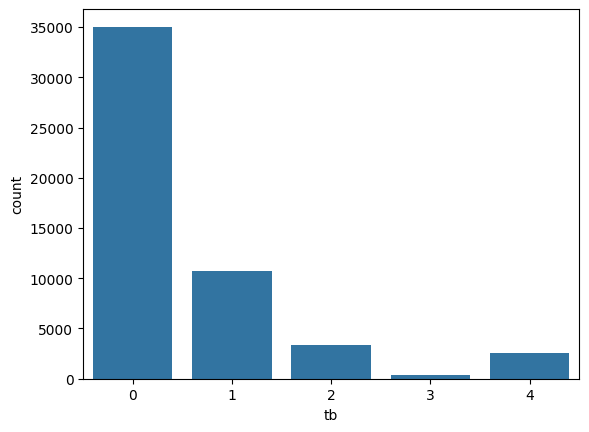

In [125]:
sns.countplot(train_data, x = "tb")

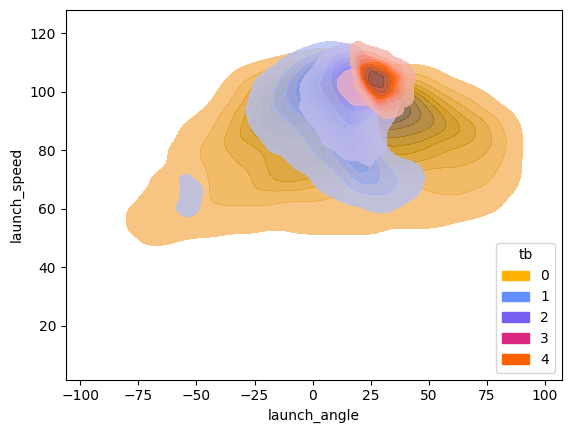

In [126]:
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2',
                  '#894D80','#16AA02','#B5592B',
                  '#A3C1ED']
custom_palette = {0: colour_palette[0], 1: colour_palette[1], 2: colour_palette[2], 3: colour_palette[3], 4: colour_palette[4]}

ax = sns.kdeplot(data = train_data, x = "launch_angle", y = "launch_speed", 
                     hue = "tb", fill = True, palette = custom_palette, alpha = 0.8)
sns.move_legend(ax, "lower right")

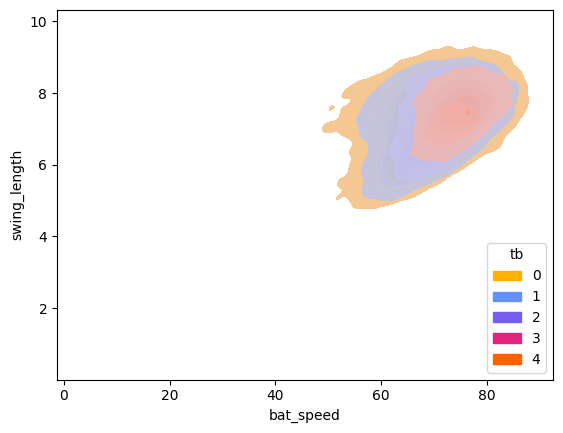

In [127]:
ax = sns.kdeplot(data = train_data, x = "bat_speed", y = "swing_length", hue = "tb", fill = True, palette = custom_palette, alpha = 0.8)
sns.move_legend(ax, "lower right")

### Model Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Create Training and Testing Data

In [13]:
target = 'tb'
seed = 1126

x = train_data.loc[:, features].values
y = train_data[target].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = seed)

In [14]:
print(len(y_train))
print(len(y_test))

46764
5196


### Random Forest

In [15]:
rf_model = RandomForestClassifier(max_depth = 8, n_estimators = 200, random_state = seed)

In [16]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=1126)

In [17]:
y_train_pred = rf_model.predict(x_train)
y_train_pred_prob = rf_model.predict_proba(x_train)
y_test_pred = rf_model.predict(x_test)
y_test_pred_prob = rf_model.predict_proba(x_test)

In [18]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)

print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     31521
           1       0.65      0.59      0.62      9618
           2       0.51      0.16      0.25      3022
           3       1.00      0.00      0.00       300
           4       0.76      0.73      0.74      2303

    accuracy                           0.79     46764
   macro avg       0.75      0.48      0.49     46764
weighted avg       0.77      0.79      0.77     46764



In [19]:
print(roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr'))

0.9083434053515838


In [20]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)

print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      3513
           1       0.62      0.57      0.60      1071
           2       0.52      0.15      0.23       330
           3       1.00      0.00      0.00        26
           4       0.75      0.71      0.73       256

    accuracy                           0.78      5196
   macro avg       0.74      0.47      0.49      5196
weighted avg       0.76      0.78      0.76      5196



In [21]:
print(roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr'))

0.8889523650757832


### SVM

In [76]:
svm = SVC(probability = True, random_state = seed)

In [77]:
svm.fit(x_train, y_train)

SVC(probability=True, random_state=1126)

In [78]:
y_train_pred = svm.predict(x_train)
y_train_pred_prob = svm.predict_proba(x_train)
y_test_pred = svm.predict(x_test)
y_test_pred_prob = svm.predict_proba(x_test)

In [79]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.99      0.82     31521
           1       0.72      0.00      0.00      9618
           2       1.00      0.00      0.00      3022
           3       1.00      0.00      0.00       300
           4       0.75      0.64      0.69      2303

    accuracy                           0.70     46764
   macro avg       0.83      0.33      0.30     46764
weighted avg       0.73      0.70      0.59     46764


AUC score: 0.8558910901848529


In [80]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.99      0.82      3513
           1       0.00      0.00      0.00      1071
           2       1.00      0.00      0.00       330
           3       1.00      0.00      0.00        26
           4       0.79      0.65      0.71       256

    accuracy                           0.70      5196
   macro avg       0.70      0.33      0.31      5196
weighted avg       0.58      0.70      0.59      5196


AUC score: 0.8602008775259924


### XGBoost

In [23]:
xgb = XGBClassifier(random_state = seed, learning_rate = 0.1, n_estimators = 100)

In [24]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
y_train_pred = xgb.predict(x_train)
y_train_pred_prob = xgb.predict_proba(x_train)
y_test_pred = xgb.predict(x_test)
y_test_pred_prob = xgb.predict_proba(x_test)

In [26]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     31521
           1       0.67      0.60      0.63      9618
           2       0.49      0.19      0.27      3022
           3       1.00      0.00      0.01       300
           4       0.75      0.74      0.75      2303

    accuracy                           0.79     46764
   macro avg       0.75      0.49      0.51     46764
weighted avg       0.78      0.79      0.77     46764


AUC score: 0.9219907475319238


In [27]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      3513
           1       0.62      0.58      0.60      1071
           2       0.45      0.15      0.23       330
           3       1.00      0.00      0.00        26
           4       0.74      0.73      0.73       256

    accuracy                           0.78      5196
   macro avg       0.73      0.47      0.49      5196
weighted avg       0.76      0.78      0.76      5196


AUC score: 0.8842916169217985


### LightGBM

In [27]:
lgb = LGBMClassifier(random_state = seed, learning_rate = 0.05, max_depth = 6)

In [28]:
lgb.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 46764, number of used features: 4
[LightGBM] [Info] Start training from score -0.394460
[LightGBM] [Info] Start training from score -1.581477
[LightGBM] [Info] Start training from score -2.739195
[LightGBM] [Info] Start training from score -5.049086
[LightGBM] [Info] Start training from score -3.010901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.05, max_depth=6, random_state=1126)

In [29]:
y_train_pred = lgb.predict(x_train)
y_train_pred_prob = lgb.predict_proba(x_train)
y_test_pred = lgb.predict(x_test)
y_test_pred_prob = lgb.predict_proba(x_test)

c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [30]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     31521
           1       0.65      0.59      0.62      9618
           2       0.49      0.18      0.26      3022
           3       1.00      0.02      0.03       300
           4       0.75      0.74      0.74      2303

    accuracy                           0.79     46764
   macro avg       0.74      0.49      0.51     46764
weighted avg       0.77      0.79      0.77     46764


AUC score: 0.9211902509868521


In [31]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      3513
           1       0.63      0.58      0.60      1071
           2       0.49      0.16      0.24       330
           3       1.00      0.00      0.00        26
           4       0.73      0.73      0.73       256

    accuracy                           0.78      5196
   macro avg       0.74      0.48      0.49      5196
weighted avg       0.77      0.78      0.77      5196


AUC score: 0.8836439745971407


Select Random Forest as my model

### Count My xwOBA

In [22]:
tmp = [0] + woba_values_2024[2:]
processed_data_2024.loc[processed_data_2024['description'] == 'hit_into_play', 'woba_pred'] = [np.sum(x) for x in rf_model.predict_proba(processed_data_2024.loc[processed_data_2024['description'] == 'hit_into_play', features].values) * tmp]

In [23]:
processed_data_2024.loc[processed_data_2024['events'] == 'walk','woba_pred'] = 0.689
processed_data_2024.loc[processed_data_2024['events'] == 'hit_by_pitch','woba_pred'] = 0.720

In [24]:
processed_data_2024.loc[processed_data_2024['woba_pred'].isna(), 'events'].value_counts()

events
strikeout                41020
strikeout_double_play      111
field_out                    1
Name: count, dtype: int64

In [25]:
processed_data_2024 = processed_data_2024.fillna(value = {'woba_pred': 0})

In [26]:
batter_df_2024 = processed_data_2024.groupby(['batter']).agg(woba_pred = ('woba_pred', 'mean'))
batter_df_2024.head()

,woba_pred
batter,
444482,0.318518
453568,0.306760
455117,0.237790
456781,0.314309
457705,0.332935


In [27]:
batter_df_2024 = batter_df_2024.reset_index()

In [29]:
excepted_data_2024 = pd.read_csv('./data/2024_excepted_data.csv')
excepted_data_2024.head()

,"last_name, first_name",player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff
0,"Duran, Jarren",680776,2024,735,515,0.285,0.271,0.014,0.492,0.448,0.044,0.357,0.338,0.019
1,"Ohtani, Shohei",660271,2024,731,479,0.310,0.314,-0.004,0.646,0.660,-0.014,0.431,0.442,-0.011
2,"Henderson, Gunnar",683002,2024,719,475,0.281,0.283,-0.002,0.529,0.492,0.037,0.381,0.374,0.007
3,"Semien, Marcus",543760,2024,718,546,0.237,0.251,-0.014,0.391,0.391,0.000,0.306,0.313,-0.007
4,"Soto, Juan",665742,2024,713,461,0.288,0.316,-0.028,0.569,0.646,-0.077,0.421,0.462,-0.041


In [30]:
batter_df_2024_merged = batter_df_2024.merge(excepted_data_2024, left_on = 'batter', right_on = 'player_id')
batter_df_2024_merged = batter_df_2024_merged.loc[:, ['player_id', 'last_name, first_name', 'woba', 'est_woba', 'woba_pred', 'pa']]
batter_df_2024_merged = batter_df_2024_merged.loc[batter_df_2024_merged['pa'] > 100, :]

In [31]:
batter_df_2024_merged.sort_values('woba_pred', ascending = False)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa
71,592450,"Judge, Aaron",0.476,0.479,0.481885,704
323,665742,"Soto, Juan",0.421,0.462,0.466482,713
254,660271,"Ohtani, Shohei",0.431,0.442,0.439030,731
320,665489,"Guerrero Jr., Vladimir",0.398,0.408,0.420357,697
433,670541,"Alvarez, Yordan",0.402,0.411,0.419566,635
...,...,...,...,...,...,...
415,669397,"Allen, Nick",0.207,0.220,0.235680,105
234,656577,"Jackson, Alex",0.200,0.223,0.232775,155
45,547989,"Abreu, José",0.164,0.198,0.230839,120
535,680779,"Davis, Henry",0.213,0.226,0.225784,122


Text(0, 0.5, 'xwOBA')

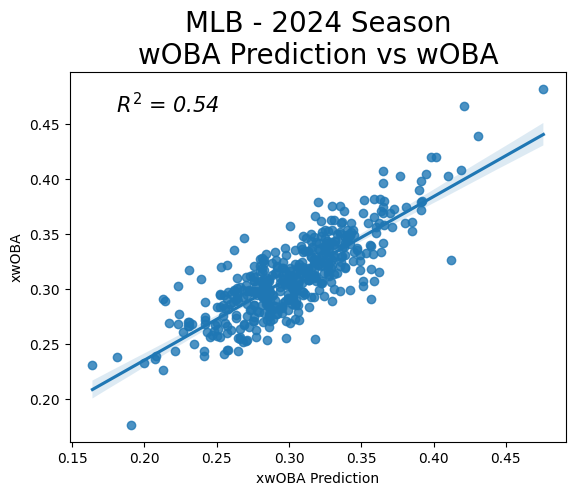

In [32]:
sns.regplot(data = batter_df_2024_merged, x = 'woba', y = 'woba_pred')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba_pred'], batter_df_2024_merged['woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nwOBA Prediction vs wOBA', fontsize = 20)
plt.xlabel('xwOBA Prediction')
plt.ylabel('xwOBA')

Text(0, 0.5, 'xwOBA (Savant)')

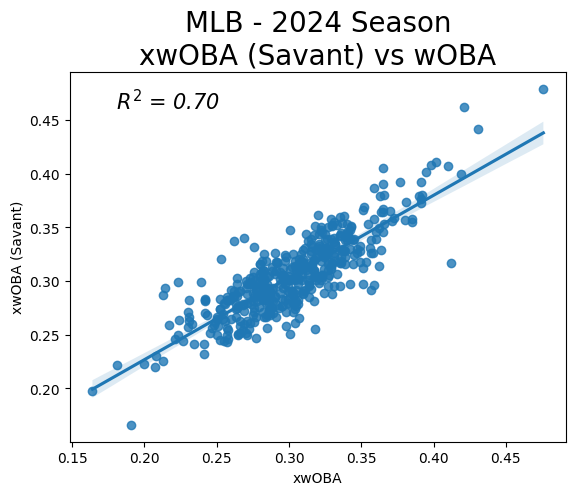

In [33]:
sns.regplot(data = batter_df_2024_merged, x = 'woba', y = 'est_woba')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba'], batter_df_2024_merged['est_woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nxwOBA (Savant) vs wOBA', fontsize = 20)
plt.xlabel('xwOBA')
plt.ylabel('xwOBA (Savant)')

Text(0, 0.5, 'xwOBA (Savant)')

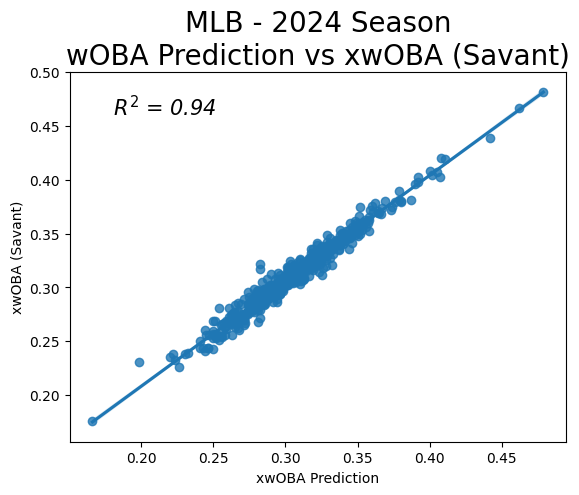

In [34]:
sns.regplot(data = batter_df_2024_merged, x = 'est_woba', y = 'woba_pred')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba_pred'], batter_df_2024_merged['est_woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nwOBA Prediction vs xwOBA (Savant)', fontsize = 20)
plt.xlabel('xwOBA Prediction')
plt.ylabel('xwOBA (Savant)')

##### xWOBA is more correlated to wOBA than my model. This implies that my model diverges more from actual outcomes. This is not necessarily a problem, as my model may simply assign higher credence to far-off outcomes, such as outs with a high likelihood of home runs. Also, my model is more correlated to xWOBA than true wOBA. This is a good sign. 

In [35]:
def add_stat_to_label(data, label):
    """add mean and std to label"""
    return label+f"\n$\mu={round(data.mean(), 3)}$\n$\sigma={round(data.std(), 3)}$"

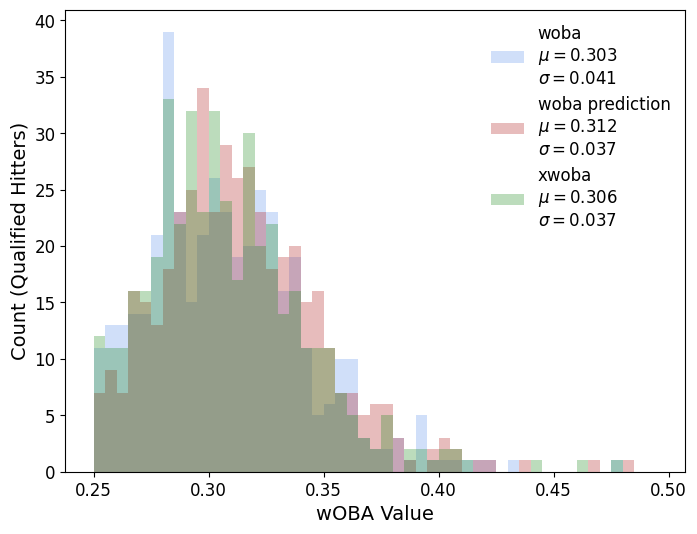

In [36]:
fig = plt.figure(figsize=(8,6))

bins = np.arange(0.25, 0.5, 0.005)

plt.hist(batter_df_2024_merged["woba"], bins = bins,
           color = "cornflowerblue", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["woba"], 'woba'))
plt.hist(batter_df_2024_merged["woba_pred"], bins = bins,
           color = "firebrick", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["woba_pred"], 'woba prediction'))
plt.hist(batter_df_2024_merged["est_woba"], bins = bins,
           color = "forestgreen", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["est_woba"], 'xwoba'))
plt.legend(frameon = False,fontsize = 12)

plt.xlabel("wOBA Value",fontsize = 14)
plt.ylabel("Count (Qualified Hitters)", fontsize = 14)
plt.tick_params(labelsize = 12)

##### According to the chart, my model tends to predict wOBA higher than the Statcast system does.

In [37]:
batter_df_2024_merged['pred_woba_difference'] = batter_df_2024_merged['woba_pred'] - batter_df_2024_merged['woba']
batter_df_2024_merged['est_woba_difference'] = batter_df_2024_merged['est_woba'] - batter_df_2024_merged['woba']
batter_df_2024_merged['pred_est_woba_difference'] = batter_df_2024_merged['woba_pred'] - batter_df_2024_merged['est_woba']

In [39]:
batter_df_2024_merged.sort_values('pred_woba_difference', ascending = False).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
140,621512,"Nido, Tomás",0.231,0.282,0.316989,140,0.085989,0.051,0.034989
603,687952,"Encarnacion-Strand, Christian",0.223,0.299,0.302592,123,0.079592,0.076,0.003592
594,687093,"Grissom, Vaughn",0.213,0.287,0.290630,114,0.077630,0.074,0.003630
641,700250,"Rice, Ben",0.269,0.340,0.346574,178,0.077574,0.071,0.006574
428,670156,"Mastrobuoni, Miles",0.214,0.294,0.288790,106,0.074790,0.080,-0.005210
506,677950,"Thomas, Alek",0.262,0.337,0.335410,103,0.073410,0.075,-0.001590
19,518934,"LeMahieu, DJ",0.239,0.299,0.309352,228,0.070352,0.060,0.010352
45,547989,"Abreu, José",0.164,0.198,0.230839,120,0.066839,0.034,0.032839
198,643265,"Cooper, Garrett",0.253,0.321,0.319711,116,0.066711,0.068,-0.001289
565,682868,"Ramos, Bryan",0.257,0.282,0.321648,108,0.064648,0.025,0.039648


In [41]:
batter_df_2024_merged.sort_values('est_woba_difference', ascending = False).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
428,670156,"Mastrobuoni, Miles",0.214,0.294,0.288790,106,0.074790,0.080,-0.005210
603,687952,"Encarnacion-Strand, Christian",0.223,0.299,0.302592,123,0.079592,0.076,0.003592
506,677950,"Thomas, Alek",0.262,0.337,0.335410,103,0.073410,0.075,-0.001590
594,687093,"Grissom, Vaughn",0.213,0.287,0.290630,114,0.077630,0.074,0.003630
641,700250,"Rice, Ben",0.269,0.340,0.346574,178,0.077574,0.071,0.006574
198,643265,"Cooper, Garrett",0.253,0.321,0.319711,116,0.066711,0.068,-0.001289
19,518934,"LeMahieu, DJ",0.239,0.299,0.309352,228,0.070352,0.060,0.010352
252,658668,"Olivares, Edward",0.276,0.332,0.320786,196,0.044786,0.056,-0.011214
140,621512,"Nido, Tomás",0.231,0.282,0.316989,140,0.085989,0.051,0.034989
357,666464,"Encarnacion, Jerar",0.301,0.348,0.357393,119,0.056393,0.047,0.009393


In [43]:
batter_df_2024_merged.sort_values('pred_est_woba_difference', ascending = False).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
565,682868,"Ramos, Bryan",0.257,0.282,0.321648,108,0.064648,0.025,0.039648
140,621512,"Nido, Tomás",0.231,0.282,0.316989,140,0.085989,0.051,0.034989
45,547989,"Abreu, José",0.164,0.198,0.230839,120,0.066839,0.034,0.032839
572,683021,"Stefanic, Michael",0.258,0.254,0.281224,124,0.023224,-0.004,0.027224
21,519317,"Stanton, Giancarlo",0.330,0.352,0.375015,459,0.045015,0.022,0.023015
18,518792,"Heyward, Jason",0.300,0.290,0.312579,258,0.012579,-0.010,0.022579
297,664034,"France, Ty",0.296,0.303,0.324749,535,0.028749,0.007,0.021749
636,695391,"Harris, Brett",0.252,0.274,0.295518,123,0.043518,0.022,0.021518
104,605204,"Davis, J.D.",0.282,0.284,0.305182,157,0.023182,0.002,0.021182
611,691023,"Walker, Jordan",0.268,0.278,0.298537,178,0.030537,0.010,0.020537


In [44]:
batter_df_2024_merged.sort_values('pred_woba_difference', ascending = True).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
422,669743,"Call, Alex",0.412,0.317,0.326532,113,-0.085468,-0.095,0.009532
342,666149,"Fitzgerald, Tyler",0.357,0.292,0.291033,341,-0.065967,-0.065,-0.000967
91,596115,"Story, Trevor",0.318,0.255,0.254578,106,-0.063422,-0.063,-0.000422
410,669364,"Edwards, Xavier",0.359,0.296,0.307387,303,-0.051613,-0.063,0.011387
540,681146,"Bride, Jonah",0.351,0.297,0.302318,272,-0.048682,-0.054,0.005318
63,578428,"Iglesias, Jose",0.362,0.314,0.315625,291,-0.046375,-0.048,0.001625
387,669003,"Mitchell, Garrett",0.351,0.312,0.306890,224,-0.044110,-0.039,-0.005110
232,656541,"Hilliard, Sam",0.342,0.297,0.298970,158,-0.043030,-0.045,0.001970
505,677942,"Alexander, Blaze",0.298,0.258,0.255675,185,-0.042325,-0.040,-0.002325
247,657136,"Wong, Connor",0.330,0.288,0.288958,487,-0.041042,-0.042,0.000958


In [45]:
batter_df_2024_merged.sort_values('est_woba_difference', ascending = True).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
422,669743,"Call, Alex",0.412,0.317,0.326532,113,-0.085468,-0.095,0.009532
342,666149,"Fitzgerald, Tyler",0.357,0.292,0.291033,341,-0.065967,-0.065,-0.000967
410,669364,"Edwards, Xavier",0.359,0.296,0.307387,303,-0.051613,-0.063,0.011387
91,596115,"Story, Trevor",0.318,0.255,0.254578,106,-0.063422,-0.063,-0.000422
540,681146,"Bride, Jonah",0.351,0.297,0.302318,272,-0.048682,-0.054,0.005318
314,665019,"Clemens, Kody",0.301,0.251,0.268988,120,-0.032012,-0.050,0.017988
63,578428,"Iglesias, Jose",0.362,0.314,0.315625,291,-0.046375,-0.048,0.001625
232,656541,"Hilliard, Sam",0.342,0.297,0.298970,158,-0.043030,-0.045,0.001970
266,662139,"Varsho, Daulton",0.304,0.261,0.272302,513,-0.031698,-0.043,0.011302
247,657136,"Wong, Connor",0.330,0.288,0.288958,487,-0.041042,-0.042,0.000958


In [46]:
batter_df_2024_merged.sort_values('pred_est_woba_difference', ascending = True).head(10)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa,pred_woba_difference,est_woba_difference,pred_est_woba_difference
526,680700,"Palacios, Richie",0.303,0.325,0.311744,316,0.008744,0.022,-0.013256
188,642180,"Wade, Tyler",0.242,0.281,0.268326,156,0.026326,0.039,-0.012674
252,658668,"Olivares, Edward",0.276,0.332,0.320786,196,0.044786,0.056,-0.011214
547,681546,"Outman, James",0.242,0.282,0.271623,156,0.029623,0.040,-0.010377
515,678877,"Noel, Jhonkensy",0.331,0.323,0.313895,198,-0.017105,-0.008,-0.009105
207,645302,"Robles, Victor",0.357,0.326,0.317673,295,-0.039327,-0.031,-0.008327
623,694192,"Chourio, Jackson",0.339,0.328,0.319790,573,-0.019210,-0.011,-0.008210
500,677594,"Rodríguez, Julio",0.321,0.344,0.335872,613,0.014872,0.023,-0.008128
557,682622,"Marte, Noelvi",0.243,0.268,0.260550,242,0.017550,0.025,-0.007450
231,656537,"Hill, Derek",0.296,0.294,0.286661,172,-0.009339,-0.002,-0.007339
